## DCv2 analysis

Scope:

- Analyze evolution of sum of squared angular distances (SSD) between samples and cluster centers w.r.t training epoch
- Perform analysis for different number of clusters used (e.g. $k = 2, 4, 6, 8, ..., 40$)

Results:

- SSD is lowest for $k = 34$
- SSD increases each epoch, and should eventually saturate and drop again, which is not observed for 800 epochs.


In [1]:
import torch
import pathlib
import numpy as np
import logging
import matplotlib.pyplot as plt

import a6
import a6.plotting._colors as _colors


a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)
logger = logging.getLogger("notebook")

device = torch.device("cpu")

plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots")

scratch = pathlib.Path("/p/scratch1/deepacf/emmerich1/dcv2")
path_k40_2_crops = scratch / "multi-level-all-fields-1964-2023"

def get_k_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[-1])


def sort_by_k(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_k_from_file_name(p))


results = sort_by_k(scratch.glob("multi-level-all-fields-1964-2023-1200-epochs-k-*"))
ks = [get_k_from_file_name(p) for p in results]
ks

[2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 34, 38, 40]

In [2]:
import torch.nn as nn
import sklearn.metrics
import itertools

def get_epoch_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[1])


def sort_by_epoch(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_epoch_from_file_name(p))


def calculate_ssds_with_mean_and_std(path: pathlib.Path) -> torch.Tensor:
    """Get the sum of squared (angular) distances between samples and cluster centers."""
    tensors_path = path / "results/tensors"
    distance_files = sort_by_epoch(tensors_path.glob("*-distances.pt"))
    centroids_files = sort_by_epoch(tensors_path.glob("*-centroids.pt"))
    embeddings_files = sort_by_epoch(tensors_path.glob("*-embeddings.pt"))
    assignments_files = sort_by_epoch(tensors_path.glob("*-assignments.pt"))

    device = torch.device("cpu")
    distances = [torch.load(file, map_location=device) for file in distance_files]
    embeddings = [torch.load(file, map_location=device) for file in embeddings_files]
    centroids = [torch.load(file, map_location=device) for file in centroids_files]
    assignments = [torch.load(file, map_location=device) for file in assignments_files]
    epochs = [get_epoch_from_file_name(file) for file in distance_files]

    logger.info("%s was chechpointed at epochs %s", path.as_posix(), epochs)

    def calculate_ssd(e: torch.Tensor, c: torch.Tensor) -> float:
        """Calculate the sum of squared angular distance (cosine distance = 1 - cosine similarity)."""
        head = -1
        crop = 1
        dot_products = torch.mm(e[head][crop], c.t())
        cos_sim, _ = dot_products.max(dim=1)
        return ((1-cos_sim)**2).sum()
    
    def calculate_accuracy_between_crops(e, c):
        accuracies = []
        for head in range(e.shape[0]):
            assignments = []
            for crop in range(e[head].shape[0]):
                dot_products = torch.mm(e[head][crop], c.t())
                _, assignment = dot_products.max(dim=1)
                assignments.append(assignment)
            accuracies.append(torch.Tensor([sklearn.metrics.accuracy_score(left, right) for left, right in itertools.pairwise(assignments)]))
        return torch.Tensor(accuracies)
        
    def calculate_distance_between_crops(e):
        cos_dist_sum = 0.0
        for head in range(e.shape[0]):
            for left, right in itertools.combinations(range(e[head].shape[0]), 2):
                for i_sample in range(e[head][left].shape[0]):
                    cos_sim = torch.dot(e[head][left][i_sample], e[head][right][i_sample])
                    cos_dist = 1 - cos_sim
                    cos_dist_sum += cos_dist
        return cos_dist_sum ** 2
    
    # ssd_per_head = [calculate_accuracy_between_crops(e, c) for e, c in zip(embeddings, centroids)]
    # ssd_per_head = [calculate_distance_between_crops(e) for e in embeddings]
    ssd_per_head = [calculate_ssd(e, c) for e, c in zip(embeddings, centroids)]
    ssd_mean = [ssd.nanmean() for ssd in ssd_per_head]
    ssd_std = [ssd.std() for ssd in ssd_per_head]

    return epochs, ssd_per_head, ssd_mean, ssd_std

ssds_six_crops = {k: calculate_ssds_with_mean_and_std(p) for k, p in zip(ks, results, strict=True)}

RANK 0 (LOCAL 0) - INFO - 2024-06-07 16:52:56 - 0:00:02 - /p/scratch1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-2 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
/tmp/ipykernel_11986/4129893730.py:63: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]
RANK 0 (LOCAL 0) - INFO - 2024-06-07 16:53:02 - 0:00:08 - /p/scratch1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-4 was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]
RANK 0 (LOCAL 0) - INFO - 2024-06-07 16:53:08 - 0:00:14 - /p/scratch1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-

/venv/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


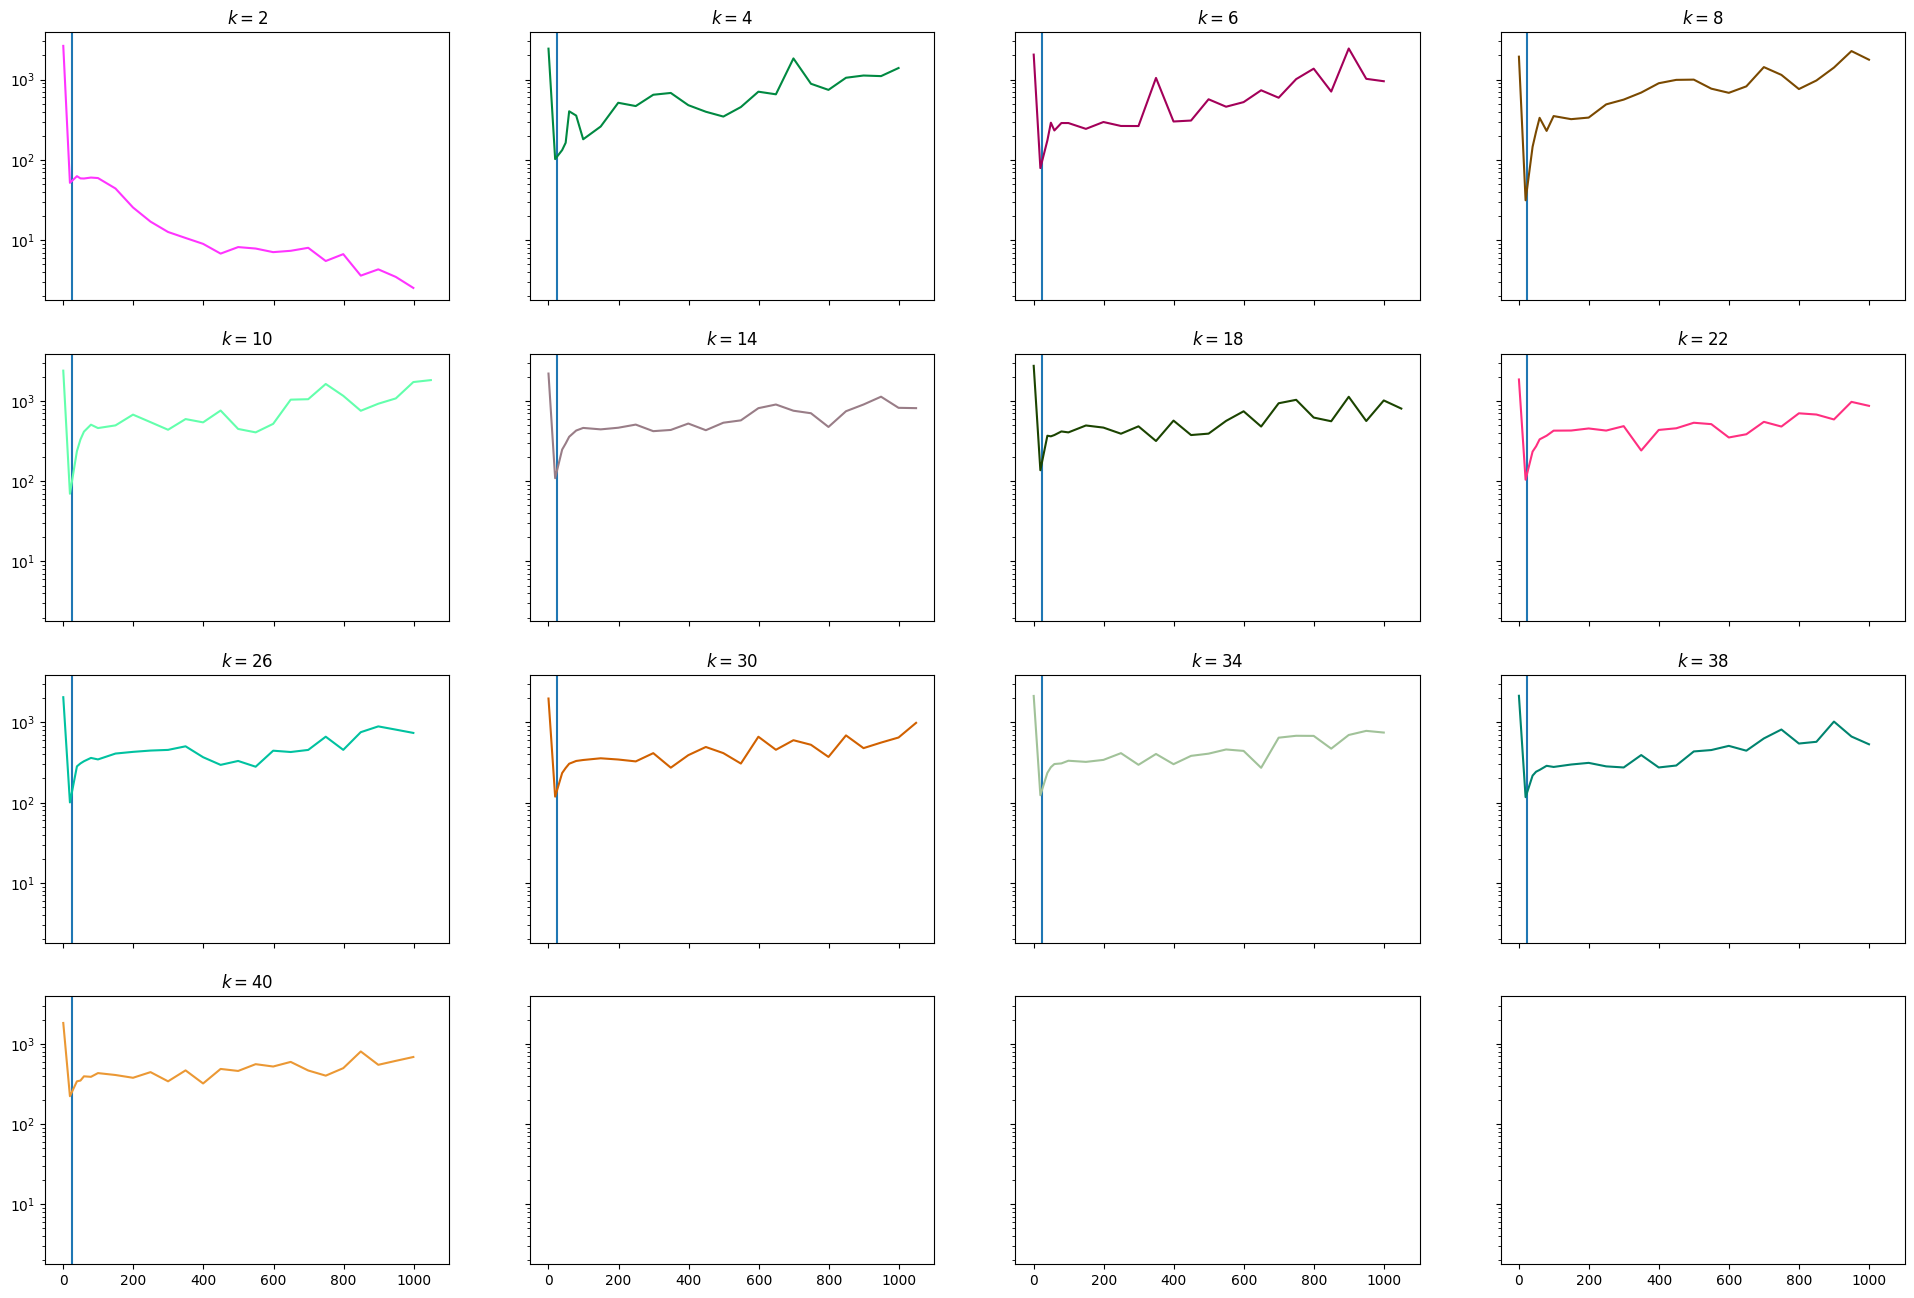

In [3]:
def plot_ssds(ssds_results, manual_scale_axis: bool = False, plot_individual: bool = False):
    colors = iter(_colors.create_colors_for_labels(ks))
    
    ncols = 4 if plot_individual else 1
    nrows = (len(ssds_results) // 4) + 1 if plot_individual else 1
    
    fig, axs = plt.subplots(figsize=(6 * ncols, 4 * nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    
    for i, (k, (epochs, ssd_per_head, ssd_mean, ssd_std)) in enumerate(ssds_results.items()):
        ax = axs.flatten()[i] if plot_individual else axs

        # if k == 2:
        #     # k = 2 is extremely different and actually has a declining SSD curve
        #     continue

        # ax.plot(epochs, ssd_mean, label=rf"${k=}$", c=next(colors))
        ax.errorbar(epochs, ssd_mean, ssd_std, label=rf"${k=}$", c=next(colors))
        
        # For individual plots, put title instead of legend
        if plot_individual:
            ax.set_title(rf"${k=}$")

        if manual_scale_axis:
            ax.set_ylim(5e9, 2e10)
            ax.set_xlim(0, 1100)

        ax.set(yscale="log")
        ax.axvline(24, 0, 1e5)
    
    # For single plot, put legend
    if not plot_individual:
        fig.legend(ncol=3, bbox_to_anchor=(1, 1), loc='upper right')
        
    plt.savefig(plots / "scree-test-dcv2-ssds.pdf")

plot_ssds(ssds_six_crops, manual_scale_axis=False, plot_individual=True)

RANK 0 (LOCAL 0) - INFO - 2024-06-07 16:58:22 - 0:05:29 - /p/scratch1/deepacf/maelstrom/emmerich1/dcv2/mnist-400-epochs was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99]
/tmp/ipykernel_11986/4129893730.py:63: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]
/venv/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


{10: ([0, 19, 39, 49, 59, 79, 99], [tensor(9008.9707), tensor(590.7518), tensor(808.3579), tensor(509.1779), tensor(706.6072), tensor(612.2544), tensor(582.0087)], [tensor(9008.9707), tensor(590.7518), tensor(808.3579), tensor(509.1779), tensor(706.6072), tensor(612.2544), tensor(582.0087)], [tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)])}


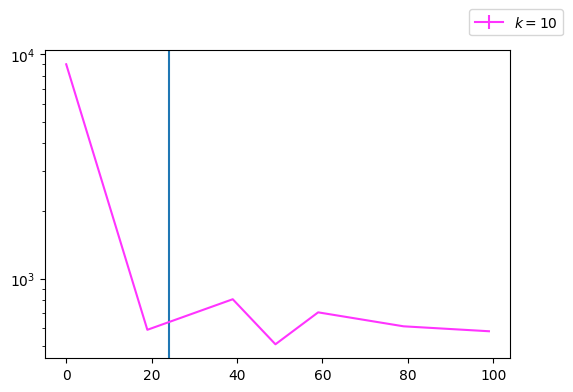

In [6]:
path_mnist = pathlib.Path("/p/scratch1/deepacf/maelstrom/emmerich1/dcv2/mnist-400-epochs")
ssds_two_crops = {10: calculate_ssds_with_mean_and_std(path_mnist)}
print(ssds_two_crops)
plot_ssds(ssds_two_crops)

RANK 0 (LOCAL 0) - INFO - 2024-06-07 16:58:28 - 0:05:35 - /p/scratch1/deepacf/emmerich1/dcv2/mnist-400-epochs was chechpointed at epochs [0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399]
/tmp/ipykernel_11986/4129893730.py:63: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  ssd_std = [ssd.std() for ssd in ssd_per_head]
/venv/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


{10: ([0, 19, 39, 49, 59, 79, 99, 149, 199, 249, 299, 349, 399], [tensor(8998.9082), tensor(493.6050), tensor(745.1984), tensor(560.5674), tensor(526.4927), tensor(798.2473), tensor(835.8258), tensor(681.1613), tensor(930.6964), tensor(1278.4148), tensor(932.8967), tensor(1133.3689), tensor(1658.1692)], [tensor(8998.9082), tensor(493.6050), tensor(745.1984), tensor(560.5674), tensor(526.4927), tensor(798.2473), tensor(835.8258), tensor(681.1613), tensor(930.6964), tensor(1278.4148), tensor(932.8967), tensor(1133.3689), tensor(1658.1692)], [tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)])}


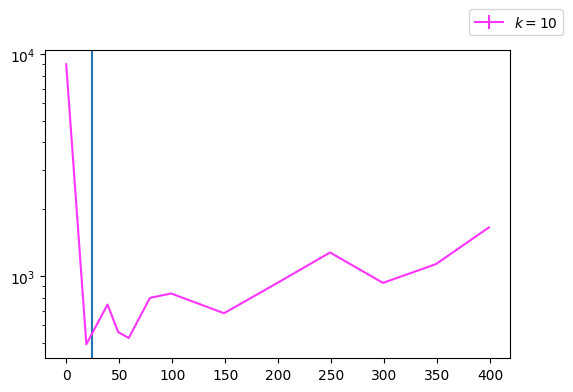

In [7]:
path_mnist = pathlib.Path("/p/scratch1/deepacf/emmerich1/dcv2/mnist-400-epochs")
ssds_mnist_8_crops = {10: calculate_ssds_with_mean_and_std(path_mnist)}
print(ssds_mnist_8_crops)
plot_ssds(ssds_mnist_8_crops)

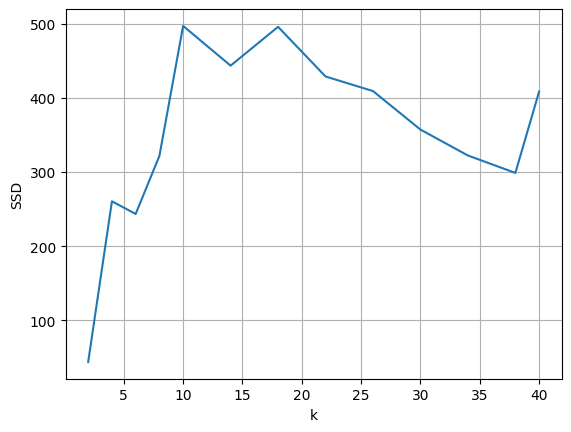

In [5]:
fig, ax = plt.subplots()

x = list(ssds_six_crops.keys())
i = 7 # index 7 corresponds to epoch 400
y = list(ssd_mean[i] for _, _, ssd_mean, _ in ssds_six_crops.values())

ax.plot(x, y)
ax.set_xlabel("k")
ax.set_ylabel("SSD")
ax.grid(True)

plt.savefig(plots / "scree-test-dcv2.pdf")


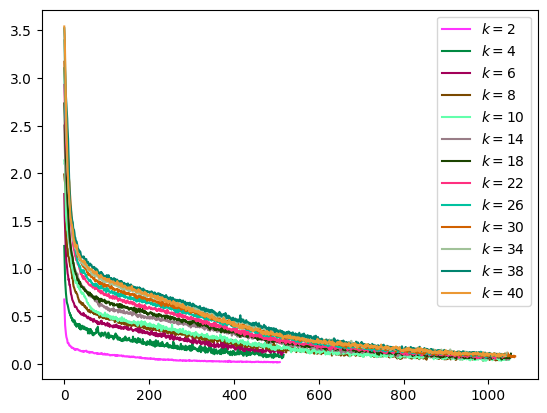

In [26]:
import pandas as pd

colors = iter(_colors.create_colors_for_labels(ks))

fig, ax = plt.subplots()

for path in results:
    metrics_0 = pd.read_csv(path / "stats-rank-0.csv")
    metrics_1 = pd.read_csv(path / "stats-rank-1.csv")
    metrics_2 = pd.read_csv(path / "stats-rank-2.csv")

    epochs = metrics_0["epoch"]
    loss_0 = metrics_0["loss"]

    ax.plot(epochs, loss_0, label=rf"$k={get_k_from_file_name(path)}$", c=next(colors))

plt.legend()